In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import skbio.diversity
import seaborn as sns
from gemelli.rpca import rpca
from gemelli.preprocessing import matrix_rclr
from gemelli.matrix_completion import MatrixCompletion
#from gemelli.factorization import rpca
from skbio.diversity import alpha_diversity
from skbio.diversity.alpha import shannon, simpson, chao1, observed_otus
from scipy.stats import mannwhitneyu
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list
import matplotlib
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("../../cleaned_asv_df.csv")
df = df.drop("Unnamed: 0", axis=1)

In [82]:
"""
#Leave away, only done to filter the outer tertiles in terms of epigenetic age deviation to check if separation gets better

# Calculate the tertiles (33rd and 66th percentiles)
lower_tertile = df['Epigenetic_deviation'].quantile(0.33)
upper_tertile = df['Epigenetic_deviation'].quantile(0.66)

# Filter the DataFrame to remove samples in the middle tertile
df = df[(df['Epigenetic_deviation'] < lower_tertile) | 
        (df['Epigenetic_deviation'] > upper_tertile)].reset_index()
df = df.drop(columns="index")
"""

'\n#Leave away, only done to filter the outer tertiles in terms of epigenetic age deviation to check if separation gets better\n\n# Calculate the tertiles (33rd and 66th percentiles)\nlower_tertile = df[\'Epigenetic_deviation\'].quantile(0.33)\nupper_tertile = df[\'Epigenetic_deviation\'].quantile(0.66)\n\n# Filter the DataFrame to remove samples in the middle tertile\ndf = df[(df[\'Epigenetic_deviation\'] < lower_tertile) | \n        (df[\'Epigenetic_deviation\'] > upper_tertile)].reset_index()\ndf = df.drop(columns="index")\n'

In [3]:
#set up reads for RPCA

if 'Row_Sum' in df.columns:
    df = df.drop(columns=['Row_Sum'])
filtered_df = df

reads_filtered = df.iloc[:,1:-13]
group_labels = filtered_df['Group']

In [4]:
# DOING ROBUST CLR-TRANSFORM AND MATRIX COMPLETION USING OPTSPACE


# Assuming filtered_rclr is a numpy array (result from matrix_rclr)
filtered_rclr = matrix_rclr(reads_filtered)

# Step 1: Create an instance of MatrixCompletion with desired parameters
mc = MatrixCompletion(n_components=3, max_iterations=5, tol=1e-5)

# Step 2: Fit the model to the filtered_rclr matrix
mc.fit(filtered_rclr)

# Step 3: Access the results, e.g., the completed matrix, sample loadings, etc.
completed_matrix = pd.DataFrame(mc.solution)
pca_sample_scores = mc.sample_weights  # U matrix
feature_weights = mc.feature_weights  # V matrix
singular_values = mc.s
explained_variance = mc.explained_variance_ratio
distance_matrix = mc.distance

/root/anaconda3/envs/SG90/lib/python3.9/site-packages/gemelli/preprocessing.py:425: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))


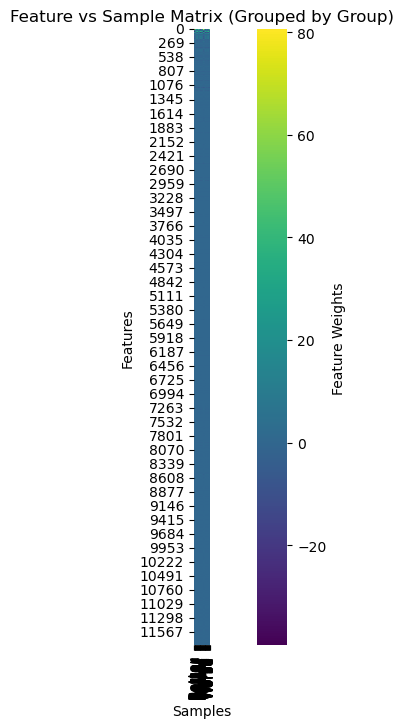

In [5]:

# Step 1: Get the group labels and sort the samples based on the group
group_labels = filtered_df['Group'].values  # Group labels for each sample
sorted_indices = np.argsort(group_labels)  # Sort indices based on group

# Step 2: Reorder the sample_weights (U matrix) based on the sorted group indices
reordered_sample_weights = pca_sample_scores[sorted_indices, :]

# Step 3: Create a DataFrame for the heatmap with sorted group labels as columns and features as rows
# Convert feature_weights (V matrix) and sample_weights (U matrix) into a combined matrix
feature_vs_sample_matrix = np.dot(feature_weights, reordered_sample_weights.T)

# Create a DataFrame for the heatmap with features as index and sorted group labels as columns
sorted_group_labels = group_labels[sorted_indices]
feature_vs_sample_df = pd.DataFrame(feature_vs_sample_matrix, index=range(feature_weights.shape[0]), columns=sorted_group_labels)

# Step 4: Create a heatmap of the feature vs sample matrix
plt.figure(figsize=(12, 8))
sns.heatmap(feature_vs_sample_df, cmap='viridis', square=True, cbar_kws={'label': 'Feature Weights'})
plt.title('Feature vs Sample Matrix (Grouped by Group)')
plt.xlabel('Samples')
plt.ylabel('Features')
plt.savefig("Feature_Samples_Heatmap.png")
plt.show()


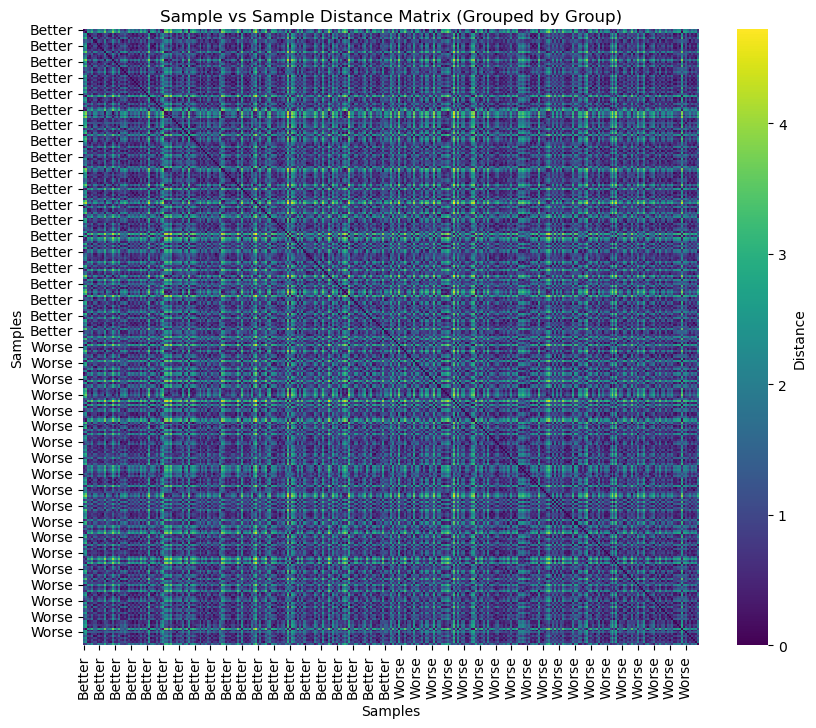

In [6]:
# Step 1: Get the group labels and sort the samples based on the group
group_labels = filtered_df['Group'].values  # Group labels for each sample
sorted_indices = np.argsort(group_labels)  # Sort indices based on group

# Step 2: Reorder the distance matrix based on the sorted group indices
reordered_distance_matrix = distance_matrix[sorted_indices, :][:, sorted_indices]

# Step 3: Create a DataFrame for the heatmap with sorted group labels as index/columns
sorted_group_labels = group_labels[sorted_indices]
distance_df = pd.DataFrame(reordered_distance_matrix, index=sorted_group_labels, columns=sorted_group_labels)

# Step 4: Create a heatmap of the reordered distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distance_df, cmap='viridis', square=True, cbar_kws={'label': 'Distance'})
plt.title('Sample vs Sample Distance Matrix (Grouped by Group)')
plt.xlabel('Samples')
plt.ylabel('Samples')
plt.savefig("Distance_Matrix.png")
plt.show()

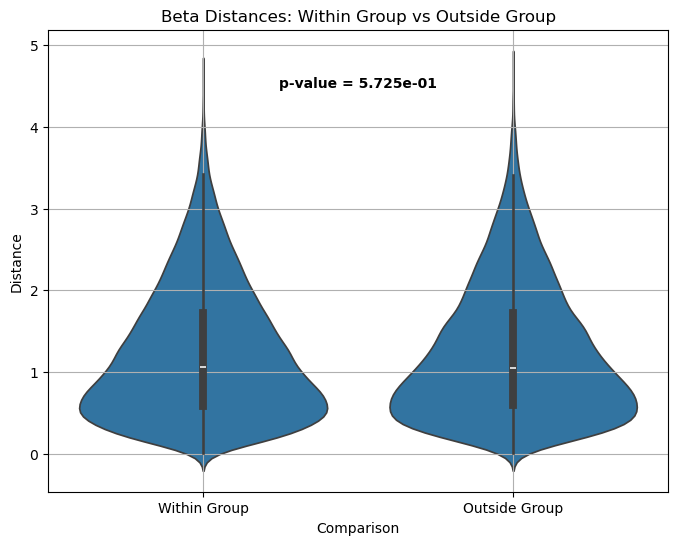

Mann-Whitney U test p-value: 0.572475718741737


In [7]:
# Step 1: Create lists to store pairwise distances and labels (within vs outside group)
within_group_distances = []
outside_group_distances = []

# Step 2: Calculate pairwise distances for within and outside groups
n_samples = distance_matrix.shape[0]
group_labels = filtered_df['Group'].values  # Group labels for each sample

for i in range(n_samples):
    for j in range(i + 1, n_samples):
        if group_labels[i] == group_labels[j]:  # Within group
            within_group_distances.append(distance_matrix[i, j])
        else:  # Outside group
            outside_group_distances.append(distance_matrix[i, j])

# Step 3: Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(within_group_distances, outside_group_distances)

# Step 4: Create a DataFrame for plotting
distance_data = pd.DataFrame({
    'Distance': within_group_distances + outside_group_distances,
    'Comparison': ['Within Group'] * len(within_group_distances) + ['Outside Group'] * len(outside_group_distances)
})

# Step 5: Create a violin plot to compare within vs outside group distances
plt.figure(figsize=(8, 6))
sns.violinplot(x='Comparison', y='Distance', data=distance_data)

# Add p-value to the plot
plt.text(0.5, max(distance_data['Distance']) * 0.95, f'p-value = {p_value:.3e}', 
         horizontalalignment='center', size='medium', color='black', weight='semibold')

plt.title('Beta Distances: Within Group vs Outside Group')
plt.ylabel('Distance')
plt.xlabel('Comparison')
plt.grid(True)
plt.savefig("R_Aitchisons_Distance.png")
plt.show()

# Print p-value for clarity
print(f'Mann-Whitney U test p-value: {p_value}')


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define color palette or specific colors for the groups
colors = {
    'Female': 'red',
    'Male': 'blue',
    'Chinese': 'green',
    'Other': 'purple',
    'Non-Smoking': 'orange',
    'Other': 'cyan',
    'Better': 'blue',   # Add a unique color for "Better"
    'Worse': 'red'    # Add a unique color for "Worse"
}

# Define a fallback color palette for other variables
default_palette = sns.color_palette("husl", len(filtered_df['Group'].unique()))

# Variables of interest
variables = ['Group', 'Age', 'BMI', 'Sex_1.0', 'Race_1.0', 'Smoking_0.0']

# Group labels for categorical variables
group_labels = {
    'Sex_1.0': {1.0: 'Female', 0.0: 'Male'},
    'Race_1.0': {1.0: 'Chinese', 0.0: 'Other'},
    'Smoking_0.0': {0.0: 'Non-Smoking', 1.0: 'Other'}
}

# Create subplots for each variable
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

# Loop through variables to generate PCA plots with density
for i, var in enumerate(variables):
    ax = axes[i]
    
    # For continuous variables, use a scatter plot with a color gradient and density plot
    if var in ['Age', 'BMI']:
        scatter = ax.scatter(
            pca_sample_scores[:, 0],  # PC1
            pca_sample_scores[:, 1],  # PC2
            c=filtered_df[var],       # Continuous variable for color
            cmap='viridis',
            alpha=0.6,
            edgecolor='k'
        )
        plt.colorbar(scatter, ax=ax, label=var)
        
        # Density plot for continuous variables with the same color as points
        sns.kdeplot(
            x=pca_sample_scores[:, 0],
            y=pca_sample_scores[:, 1],
            ax=ax,
            fill=True,
            cmap='viridis',  # Use the same color map for density
            alpha=0.3,
            thresh=0.05,
            levels=5
        )

    # For categorical variables, use different colors for each category and add density
    else:
        unique_groups = filtered_df[var].unique()
        label_dict = group_labels.get(var, {g: g for g in unique_groups})
        
        for group in unique_groups:
            group_indices = filtered_df[var] == group
            group_label = label_dict[group]
            color = colors.get(group_label, 'blue')  # Get the color for the group
            
            # Scatter plot
            ax.scatter(
                pca_sample_scores[group_indices, 0],  # PC1
                pca_sample_scores[group_indices, 1],  # PC2
                label=group_label,
                alpha=0.6,
                color=color,  # Set scatter color
                edgecolor='k'
            )
            
            # Density plot for the group
            sns.kdeplot(
                x=pca_sample_scores[group_indices, 0],
                y=pca_sample_scores[group_indices, 1],
                ax=ax,
                color=color,  # Use the same color for density
                alpha=0.3,
                fill=True,
                thresh=0.05,
                levels=2
            )
        
        ax.legend(title=var)

    # Add axis labels and titles
    ax.set_xlabel('PC1 (%.2f%% variance explained)' % (explained_variance[0] * 100))
    ax.set_ylabel('PC2 (%.2f%% variance explained)' % (explained_variance[1] * 100))
    ax.set_title(f'PCA by {var}')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the full figure with all variables
fig.savefig('all_combined_pca_plots.png', dpi=300)

# Save the figure specifically for 'Group'
group_fig = plt.figure(figsize=(8, 6))
ax_group = group_fig.add_subplot(111)

# Plotting for Group with density
unique_groups = filtered_df['Group'].unique()
for group in unique_groups:
    group_indices = filtered_df['Group'] == group
    group_label = group  # Assuming 'Group' column already contains readable labels
    color = colors.get(group_label, 'blue')  # Get color for the group

    # Scatter plot for 'Group'
    ax_group.scatter(
        pca_sample_scores[group_indices, 0],  # PC1
        pca_sample_scores[group_indices, 1],  # PC2
        label=group_label,
        alpha=0.6,
        color=color,  # Set scatter color
        edgecolor='k'
    )
    
    # Density plot for 'Group'
    sns.kdeplot(
        x=pca_sample_scores[group_indices, 0],
        y=pca_sample_scores[group_indices, 1],
        ax=ax_group,
        color=color,  # Set density color to match scatter
        alpha=0.3,
        fill=True,
        thresh=0.05,
        levels=2
    )

ax_group.set_xlabel('PC1 (%.2f%% variance explained)' % (explained_variance[0] * 100))
ax_group.set_ylabel('PC2 (%.2f%% variance explained)' % (explained_variance[1] * 100))
ax_group.set_title('PCA by Group')
ax_group.grid(True)
ax_group.legend(title='Group')

# Save the figure
group_fig.savefig('pca_by_group.png')

# Show the full figure with all variables
plt.show()


In [ ]:
#remarks:
# total variance equals to 100 bc matrix completion method is based on explaining variance in 2 components (intended as rank). 
# higher components not feasible
# smoking plot probably wrong level assignment, not important for now though


# Replace NaN values with 0
filtered_rclr = np.nan_to_num(filtered_rclr, nan=0.0)

# Perform PCA on the scaled data
pca = PCA(n_components=303)
pca_sample_scores = pca.fit_transform(filtered_rclr)

# Check explained variance
explained_variance_ratio = pca.explained_variance_ratio_

print("Explained Variance by the first 2 components of regular PCA on RCLR transformed data with high sparsity:\n", explained_variance_ratio[0:2])
print("Total variance explained by all components (sanity check):", explained_variance_ratio.sum())
